In [1]:
# Proceess the long-term hindcasts from MPI, courtesy of Leo

var = 'SST'

In [2]:
import numpy as np
import glob
import pickle
import os
from scipy import stats
import time
import mfilter
import random
from scipy import interpolate
import sys
import netCDF4
from cmip import *
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
datadir = '/modfs/project/EUCP/lborchert/MPI-HC-CMIP5'
basedir = '/home/mmenary/python/notebooks/cmip6_2/output/'
save_file = '/data/mmenary/python_saves/MPI_LongHinds_{:s}_TimeSeries.pkl'.format(var)
save_file2 = '/data/mmenary/python_saves/MPI_LongHinds_{:s}_AnnualMapCMIPStyleRegridded.pkl'.format(var)

ens_mems = ['08', '22', '26']
nmems = len(ens_mems)

nleads = 11

years = 1900 + np.arange(110)
nyrs = len(years)

file_template = '{:s}_{:s}mon_MPI-ESM-LR_dec{:s}o{:d}_r1i1p1_{:d}01-{:d}12.nc'

if var == 'SST':
    var2 = 'tos'
    realm = 'O'
    regions = ['north_atlantic', 'subpolar_gyre', 'intergyre', 'tropical_atlantic_north',
               'tropical_atlantic_south', 'global', 'global60', 'nh', 'spg_rahmstorf',
               'spg_menary18', 'spg_leo20']
    lon_vertices = 'lon_vertices'
    lat_vertices = 'lat_vertices'
    obs_save_file = '/data/mmenary/python_saves/HadISST_time_series_regions.pkl'
elif var == 'SAT':
    var2 = 'tas'
    realm = 'A'
    regions = ['europe1']
    lon_vertices = 'lon_bnds'
    lat_vertices = 'lat_bnds'
    obs_save_file = '/data/mmenary/python_saves/HadCRUT4_time_series_regions.pkl'

In [4]:
def regrid_arr(arr_in, year_in, lon_in, lat_in):
    nyrs = len(year_in)
    arr_regridded = np.ma.masked_all(shape=(nyrs, nj_re, ni_re))
    
    print lat_in.shape, lon_in.shape, arr_in.shape, lat_re.shape, lon_re.shape, arr_regridded.shape

    for tt in range(nyrs):
        print('{:d}'.format(tt))
        arr_regridded[tt, :, :] = interpolate.griddata(np.array([lat_in.ravel(), lon_in.ravel()]).T,
                                                       arr_in[tt, :, :].ravel(), (lat_re, lon_re),
                                                       method='linear')
    mask_regridded = interpolate.griddata(np.array([lat_in.ravel(), lon_in.ravel()]).T,
                                          arr_in[0, :, :].mask.ravel(), (lat_re, lon_re),
                                          method='linear')
    arr_regridded = np.ma.array(arr_regridded, mask=np.repeat(mask_regridded[np.newaxis, :, :], nyrs, axis=0))
    return arr_regridded

nj_re = 180
ni_re = 360
lon_re = np.repeat((np.arange(-180, 180) + 0.5)[np.newaxis, :], nj_re, axis=0)
lat_re = np.repeat((np.arange(-90, 90) + 0.5)[:, None], ni_re, axis=1)

In [5]:
if os.path.isfile(save_file) and os.path.isfile(save_file2):
    with open(save_file, 'rb') as handle:
        mpi_longhinds, years = pickle.load(handle)
    with open(save_file2, 'rb') as handle:
        sst_ann, years = pickle.load(handle)
else:
    mpi_longhinds = {}
    for region in regions:
        mpi_longhinds[region] = np.ma.masked_all(shape=(nmems, nyrs, nleads))

    sst_ann = np.ma.masked_all(shape=(nyrs, nmems, nleads, nj_re, ni_re))

    for iyr, year in enumerate(years):
        for iens, ens_mem in enumerate(ens_mems):
            print "{:d}-{:d}".format(year, iens+1)
            base_file = file_template.format(var2, realm, ens_mem, year, year+1, year+10)
            infile = os.path.join(datadir, base_file)

            if not os.path.isfile(infile):
                raise ValueError('Where is this file? {:s}'.format(infile))

            loaded = netCDF4.Dataset(infile)
            sst_in = np.ma.array(loaded.variables[var2][:]) - 273.15
            time_in = loaded.variables['time'][:]

            if (iyr == 0) and (iens == 0):
                lon_in = loaded.variables['lon'][:]
                lat_in = loaded.variables['lat'][:]
                lon_v_in = loaded.variables[lon_vertices][:]
                lat_v_in = loaded.variables[lat_vertices][:]

                if lon_in.ndim < 2:
                    nj = len(lat_in)
                    ni = len(lon_in)
                    lon_in = np.repeat(lon_in[np.newaxis, :], nj, axis=0)
                    lat_in = np.repeat(lat_in[:, np.newaxis], ni, axis=1)
                    lon_v_in = np.repeat(lon_v_in[np.newaxis, :, :], nj, axis=0)
                    lat_v_in = np.repeat(lat_v_in[:, np.newaxis, :], ni, axis=1)

                # Make the longitudes -180 -> +180
                lon_in = (lon_in + 360.) % 360.
                lon_in[lon_in > 180] -= 360
                lon_v_in = (lon_v_in + 360.) % 360.
                lon_v_in[lon_v_in > 180] -= 360

                xdist = arc_length(lon_v_in, lat_v_in)
                xdist = np.ma.array(xdist, mask=sst_in[0, :, :].mask)
                ydist = arc_length(lon_v_in, lat_v_in, j_direction=True)
                ydist = np.ma.array(ydist, mask=sst_in[0, :, :].mask)
                area = xdist * ydist

            # Make annual mean
            nt_in, nj_in, ni_in = sst_in.shape
            sst_am = np.ma.masked_all(shape=(nt_in/12, nj_in, ni_in))
            for tt in range(nt_in/12):
                sst_am[tt, :, :] = np.ma.mean(sst_in[tt*12:(tt+1)*12-1, :, :], axis=0)

            # Store annual mean TODO Check init time, first ann mean validity time
            sst_am_re = regrid_arr(sst_am, np.arange(nt_in/12), lon_in, lat_in)
            sst_ann[iyr, iens, 1:, :, :] = sst_am_re

            # Store time series
            for region in regions:
                # From 1: because I've decided t=0 is the year of initialisation (i.e. the assim)
                mpi_longhinds[region][iens, iyr, 1:] = make_ts_2d(sst_am, lon_in, lat_in, area, region)

    with open(save_file, 'wb') as handle:
        print "Writing to {:s}".format(save_file)
        pickle.dump([mpi_longhinds, years], handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(save_file2, 'wb') as handle:
        print "Writing to {:s}".format(save_file2)
        pickle.dump([sst_ann, years], handle, protocol=pickle.HIGHEST_PROTOCOL)

print "++ COMPLETE"

++ COMPLETE


In [6]:
with open(obs_save_file, 'rb') as handle:
    print "Loading save file: {:s}".format(obs_save_file)
    _, obs, _, year_obs = pickle.load(handle)

Loading save file: /data/mmenary/python_saves/HadISST_time_series_regions.pkl


In [ ]:
if var != 'SAT':
    raise ValueError('Next bit is only for when looking at SAT (not SST) currently')

In [60]:
analogue_example_file = '/modfs/ipslfs/dods/mmenary/AnalogueCache/ANALOGUESST_FORECASTSAT_DOMAIN+30+20+05-60_TARGETeurope1_WINDOW10_MEMS20_Smo11_SpatialSkill_RMSEmethod.pkl'
with open(analogue_example_file, 'rb') as handle:
    _, _, _, _, trend_corr_info, trend_forecast, trend_forecast_means, trend_forecast_sds = pickle.load(handle)
    
from analogue import *
trend_forecast_recentred = recentre_forecast(trend_forecast, 20, trend_forecast_means, trend_forecast_sds,
                                             obs['europe1'], 10, clever_scaling_method=True)


analogue_map_example_file = '/modfs/ipslfs/dods/mmenary/AnalogueCache/ForecastMaps_EnsMnExpanded_ANALOGUESST_DOMAIN+30+20+05-60_TARGETeurope1_WINDOW10_MEMS20_SpatialSkill_Smo11_RMSEmethod.pkl'
with open(analogue_map_example_file, 'rb') as handle:
    obs_map_expanded, _, forecast_map_ensmn_stdsd_expanded = pickle.load(handle)
year_forecast_obs = 1850 + np.arange(169)
    

CLEVER


/home/mmenary/python/notebooks/cmip6_2/output/MPI_LongHinds_SAT_TimeSeries_anom.png


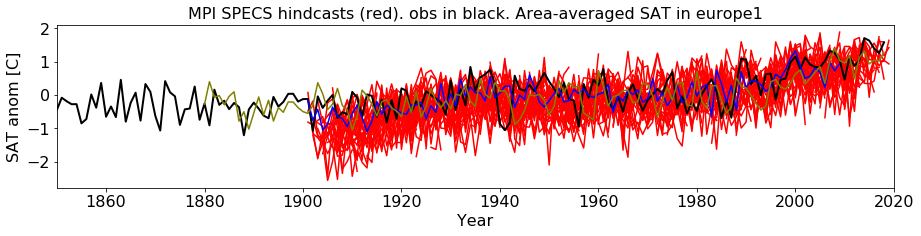

In [56]:
anom = True

if anom:
    y0, y1 = 1960, 1990
    t0 = np.argwhere(year_obs == y0)[0][0]
    t1 = np.argwhere(year_obs == y1)[0][0]
    t0f = np.argwhere(years == y0)[0][0]
    t1f = np.argwhere(years == y1)[0][0]
    forecast_mean = {}
    for region in regions:
        forecast_mean[region] = np.ma.mean(mpi_longhinds[region][:, t0f:t1f, :])
    anom_string = '_anom'
else:
    anom_string = ''

nregions = len(regions)
fontsize = 16

plt.figure(figsize=(15, nregions*3))
for ireg, region in enumerate(regions):
    plt.subplot(nregions, 1, ireg+1)
    for iens, ens_mem in enumerate(ens_mems):
        for iyr, year in enumerate(years):
            forecast = mpi_longhinds[region][iens, iyr, :].copy()
            if anom:
                forecast -= forecast_mean[region]
            plt.plot(years[iyr] + np.arange(nleads), forecast, color='red')
    plt.title('MPI SPECS hindcasts (red). obs in black. Area-averaged {:s} in {:s}'.format(var, region), fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    if anom:
        plt.ylabel('{:s} anom [C]'.format(var), fontsize=fontsize)
        plt.plot(year_obs, obs[region] - obs[region][t0:t1].mean(), color='k', lw=2)
        plt.plot(years[1:], np.ma.mean(mpi_longhinds[region][:, :-1, 1], axis=0)-np.ma.mean(mpi_longhinds[region][:, :-1, 1], axis=0).mean(), color='blue')
    else:
        plt.ylabel('{:s} [C]'.format(var), fontsize=fontsize)
        plt.plot(year_obs, obs[region], color='k', lw=2)
        plt.plot(years[1:], np.ma.mean(mpi_longhinds[region][:, :-1, 1], axis=0), color='blue')
    plt.xlim(1850, 2020)
    if ireg == (nregions - 1):
        plt.xticks(fontsize=fontsize)
        plt.xlabel('Year', fontsize=fontsize)
    else:
        plt.xticks([])
        
if anom:
    plt.plot(year_obs[1:], trend_forecast_recentred[:-1, 1]-trend_forecast_recentred[:-1, 1].mean(), color='olive')
else:
    plt.plot(year_obs[1:], trend_forecast_recentred[:-1, 1], color='olive')
        
fig_save_file = '{:s}MPI_LongHinds_{:s}_TimeSeries{:s}.png'.format(basedir, var, anom_string)
print fig_save_file
plt.savefig(fig_save_file, bbox_inches = 'tight')

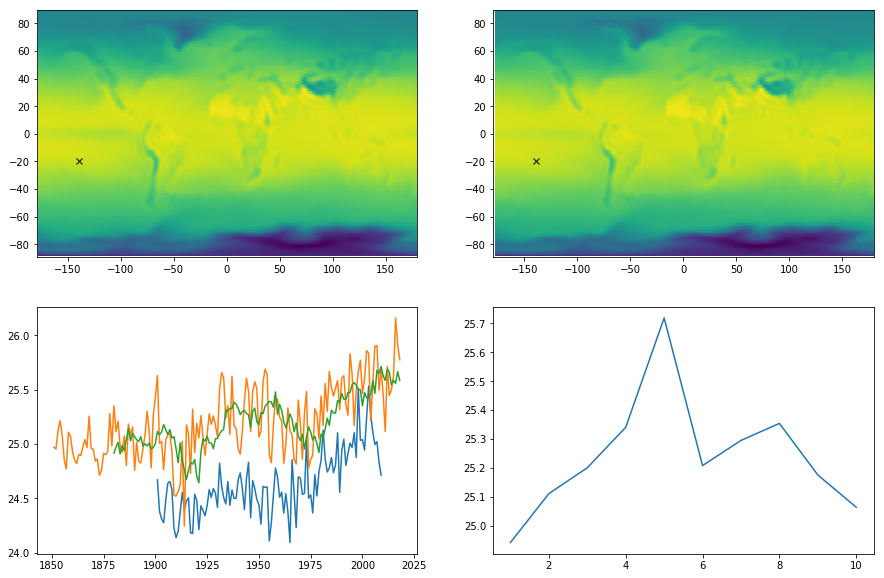

In [64]:
sst_ann_ensmn = np.ma.mean(sst_ann, axis=1)

jj, ii = 70, 40

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.pcolormesh(lon_re, lat_re, sst_ann_ensmn[0, 1, :, :])
plt.plot(lon_re[jj, ii], lat_re[jj, ii], 'x', color='k')

plt.subplot(2, 2, 2)
plt.pcolormesh(lon_re, lat_re, sst_ann_ensmn[0, 10, :, :])
plt.plot(lon_re[jj, ii], lat_re[jj, ii], 'x', color='k')

plt.subplot(2, 2, 3)
plt.plot(sst_ann_ensmn[:-1, 1, jj, ii])

plt.subplot(2, 2, 4)
plt.plot(sst_ann_ensmn[100, :, jj, ii])

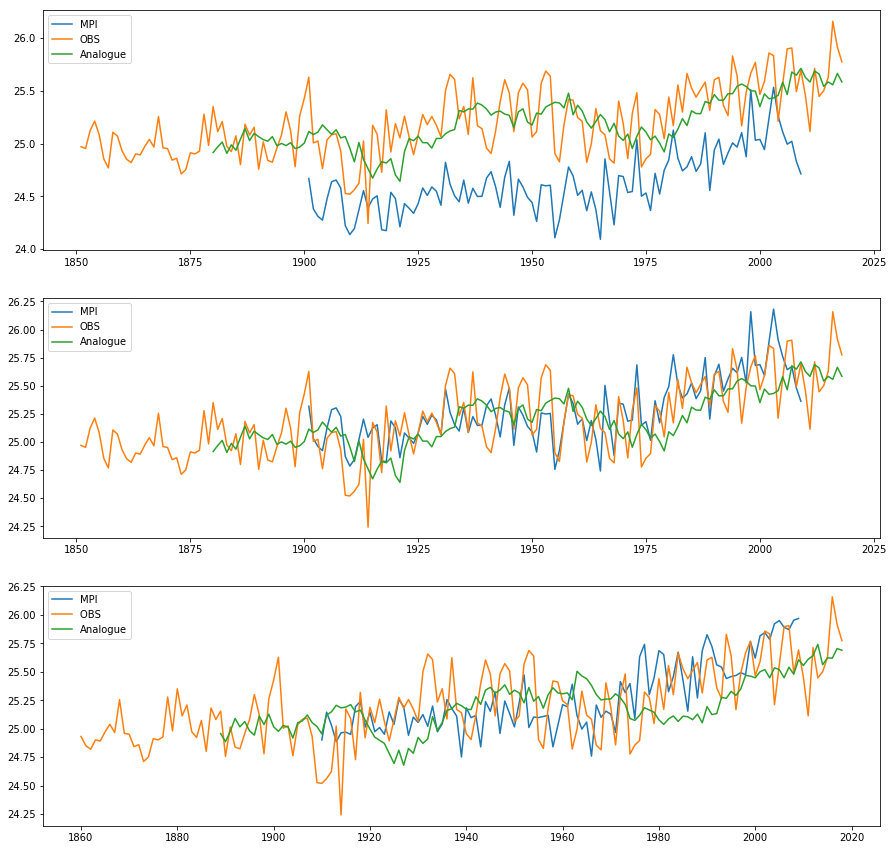

In [72]:
plt.figure(figsize=(15, 15))

plt.subplot(3, 1, 1)
plt.plot(years[1:], sst_ann_ensmn[:-1, 1, jj, ii], label='MPI')
plt.plot(year_forecast_obs[1:], obs_map_expanded[1:, jj, ii], label='OBS')
plt.plot(year_forecast_obs[1:], forecast_map_ensmn_stdsd_expanded[:-1, 1, jj, ii], label='Analogue')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(years[1:], sst_ann_ensmn[:-1, 1, jj, ii]+(obs_map_expanded[51:, jj, ii].mean()-sst_ann_ensmn[:-1, 1, jj, ii].mean()), label='MPI')
plt.plot(year_forecast_obs[1:], obs_map_expanded[1:, jj, ii], label='OBS')
plt.plot(year_forecast_obs[1:], forecast_map_ensmn_stdsd_expanded[:-1, 1, jj, ii], label='Analogue')
plt.legend()

lt = 10

plt.subplot(3, 1, 3)
plt.plot(years[lt:], sst_ann_ensmn[:-lt, lt, jj, ii]+(obs_map_expanded[51:, jj, ii].mean()-sst_ann_ensmn[:-lt, lt, jj, ii].mean()), label='MPI r={:.2f}'.format(mpi_corr))
plt.plot(year_forecast_obs[lt:], obs_map_expanded[lt:, jj, ii], label='OBS')
plt.plot(year_forecast_obs[lt:], forecast_map_ensmn_stdsd_expanded[:-lt, lt, jj, ii], label='Analogue r={:.2f}'.format(ana_corr))
plt.legend()

In [92]:
lt = 1

xx = sst_ann_ensmn[:-lt, lt, jj, ii]
yy = obs_map_expanded[lt:, jj, ii][50:-9]

xx2 = years[lt:]
yy2 = year_forecast_obs[lt:][50:-9]

mpi_corr = np.corrcoef(xx, yy)[0][1]

xx = forecast_map_ensmn_stdsd_expanded[:-lt, lt, jj, ii]
yy = obs_map_expanded[lt:, jj, ii]

ana_corr = np.corrcoef(xx, yy)[0][1]

xx = forecast_map_ensmn_stdsd_expanded[:-lt, lt, jj, ii][50:-9]
yy = obs_map_expanded[lt:, jj, ii][50:-9]

ana_corr2 = np.corrcoef(xx, yy)[0][1]

print mpi_corr, ana_corr, ana_corr2

0.6702817143705619 0.3439004934860964 0.556895580598925


In [90]:
print mpi_corr, ana_corr, ana_corr2

0.4976168705467359 0.33332549521098453 0.3243412343441055


In [86]:
np.corrcoef(xx, yy)[0][1]

0.33332549521098453